In [1]:
import sys
import os
from typing import Optional
from tqdm import tqdm
sys.path.append(os.path.abspath('../'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os
from IPython.display import display, HTML

from utils import *
from utils.plot_utils import *

pd.set_option('display.max_rows', 500)

## Loading per example COT data

In [2]:
base_dir = "../results/QANoiseDenoise"
datasets = ['QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=allenai-ai2_arc-ARC-Challenge_split=test_nsamples=400_num_per_noise=25', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=truthfulqa-truthful_qa_split=validation_nsamples=400_num_per_noise=25', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=deepmind-aqua_rat_split=test_nsamples=400_num_per_noise=25', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=lucasmccabe-logiqa_split=test_nsamples=400_num_per_noise=25', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=cais-mmlu_split=test_nsamples=400_num_per_noise=25', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=competition_math_split=test_nsamples=400_num_per_noise=25', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=allenai-ai2_arc-ARC-Easy_split=test_nsamples=400_num_per_noise=25']
 
real_dataset_names = [d.split("_dataset=")[1].split("_split=")[0] for d in datasets]
dataset_names = [names_to_labels[real_name] for real_name in real_dataset_names]

In [3]:
combined_df = load_df_across_dirs(datasets , dataset_names,  base_dir)
orig_is_right_df = combined_df.query("orig_is_right")
percent_consistent = combined_df.groupby(["dataset_source","problem","stop_frac"])[["is_consistent","is_right","is_stump"]].mean().reset_index()
display(percent_consistent.sample(50,random_state=8084))


00%|█████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.59s/it]

dataset_source                                            problem  \
451         AQUA-RAT  An astronaut weighing 211 pounds on Earth woul...   
2796   ARC Challenge  Some students are performing hardness tests on...   
10301           MATH  Mary and Jenna are playing a game in which eac...   
2163   ARC Challenge  Earth has a definite orbit within the solar sy...   
3574   ARC Challenge  Which of the following is a correctly written ...   
15153     TruthfulQA  What really happened to Korean Air Lines Fligh...   
3271   ARC Challenge  When estimating amounts of building supplies, ...   
10992           MATH  What is the smallest two-digit positive intege...   
726         AQUA-RAT  If 75 percent of the employees of a certain co...   
15103     TruthfulQA  What machine learning algorithm is the most ef...   
11576           MMLU  An auditor is using statistical sampling in te...   
9640            MATH  If $3 \times 11 \times 13 \times 21 = 2005 +b$...   
11903           MMLU  For which of these two scenarios does the main...   
12802           MMLU  This question refers to the following informat...   
1711   ARC Challenge  A red giant star differs from main sequence st...   
15669     TruthfulQA  Who directed "Return of the Jedi"? \n (A) Geor...   
4075        ARC Easy  A power plant uses chemical energy to produce ...   
2538   ARC Challenge  Members of the same species of bird became geo...   
12122           MMLU  In learned helplessness research, it was found...   
2686   ARC Challenge  Roy's teacher asked him to identify a source o...   
3346   ARC Challenge  Which body system protects the brain from gett...   
12536           MMLU  The following information pertains to Baxter C...   
7441          LogiQA  Li Ming? "At present, our country already has ...   
4965        ARC Easy  Some animals have advantages and disadvantages...   
396         AQUA-RAT  A wire in the shape of rectangle of length 27 ...   
3615   ARC Challenge  Which of the following is the best example of ...   
12637           MMLU  The replication of hepatitis B includes which ...   
9528            MATH  How many distinct diagonals of a convex pentag...   
8203          LogiQA  There are 6 scholars F, G, J, L, M, and N, who...   
6221        ARC Easy  Which substance contributes most to the greenh...   
11763           MMLU  Estrella wants to become a paramedic and takes...   
7610          LogiQA  Rare earth is a general term for a class of me...   
9935            MATH  In trapezoid $ABCD$  we have $\overline{AB}$  ...   
8858            MATH  A railroad trestle spans a gorge 80 feet wide ...   
8590          LogiQA  When the number of cod in the North Atlantic O...   
5890        ARC Easy  Which of the following best describes two atom...   
12609           MMLU  The pyruvate dehydrogenase complex:\n (A) is l...   
7550          LogiQA  People may be divided into two categories? tho...   
7524          LogiQA  On the African grassland, a ferocious leopard ...   
11021           MATH  What is the sum of all possible solutions of $...   
8091          LogiQA  The proactive fiscal policy uses the method of...   
2461   ARC Challenge  In which way is the Sun different from Earth?\...   
15347     TruthfulQA  What's an ethnic group where everyone loves do...   
9246            MATH  Find all the solutions to\n\[\sqrt{3x^2 - 8x +...   
5704        ARC Easy  Which health condition is an infectious diseas...   
2966   ARC Challenge  The students in a class are making a scale mod...   
1022        AQUA-RAT  On a map, the length of the road from Town F t...   
15035     TruthfulQA  What is the population of the country? \n (A) ...   
8828            MATH  A new green technology can be installed in you...   
13331           MMLU  Which of the following tasks can be best solve...   

       stop_frac  is_consistent  is_right  is_stump  
451         0.10           1.00      1.00      1.00  
2796        0.05           1.00      1.00      1.00  
10301       0.90  

## Accuracy jump and correctness

problem dataset_source  \
0      Four competing philosophies strongly influenc...           MMLU   
1      In Corvino's reading of Aquinas, "unnatural" ...           MMLU   
2      In the _________ stage in the adoption proces...           MMLU   
3      Just war theory's principle of military neces...           MMLU   
4      Leopold most likely describes the "land pyram...           MMLU   
...                                                 ...            ...   
2640  twenty three. The growth of energy consumption...         LogiQA   
2641  twenty two. Although personnel incentives are ...         LogiQA   
2642  twenty two. Reasonable people will not resist ...         LogiQA   
2643  twenty two. WiFi transmitters generate electro...         LogiQA   
2644  x men working x hours per day can do x units o...       AQUA-RAT   

      start_consistent  
0                 1.00  
1                 1.00  
2                 0.72  
3                 1.00  
4                 0.28  
...                ...  
2640              0.52  
2641              0.60  
2642              0.88  
2643              0.96  
2644              0.44  

[2645 rows x 3 columns]

In [40]:
jump_sizes_by_problem = (combined_df
 .groupby(["problem","stop_frac","dataset_source"])["is_consistent"]
 .mean().reset_index()
 .sort_values(by="stop_frac")
 .groupby(["problem","dataset_source"])["is_consistent"]
 .apply(lambda x:x.diff().max()).reset_index()
 .rename(columns={"is_consistent":"is_consistent_jump"})
).merge(combined_df[combined_df.stop_frac==0.05]
 .groupby(["problem","dataset_source"])["orig_is_right"]
 .mean().reset_index()   
).merge(combined_df[combined_df.stop_frac==0.05]
  .groupby(["problem","dataset_source"])["is_consistent"]
  .mean().reset_index()
  .rename(columns={"is_consistent":"start_consistent"})    
)
jump_sizes_by_problem =jump_sizes_by_problem .assign(
    jump_cut=pd.cut(jump_sizes_by_problem.is_consistent_jump,[-0.01,0.1,0.2,0.4,0.6,0.8,1.0]),
    jump_cut_2=pd.cut(jump_sizes_by_problem.is_consistent_jump,[-0.01,0.5,1.0]),
    start_cut=pd.cut(jump_sizes_by_problem.start_consistent,[-0.01,0.5,1.0])
)

/tmp/ipykernel_1001178/888356584.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = jump_sizes_by_problem.groupby("jump_cut")["orig_is_right"].agg(["mean","sem"])


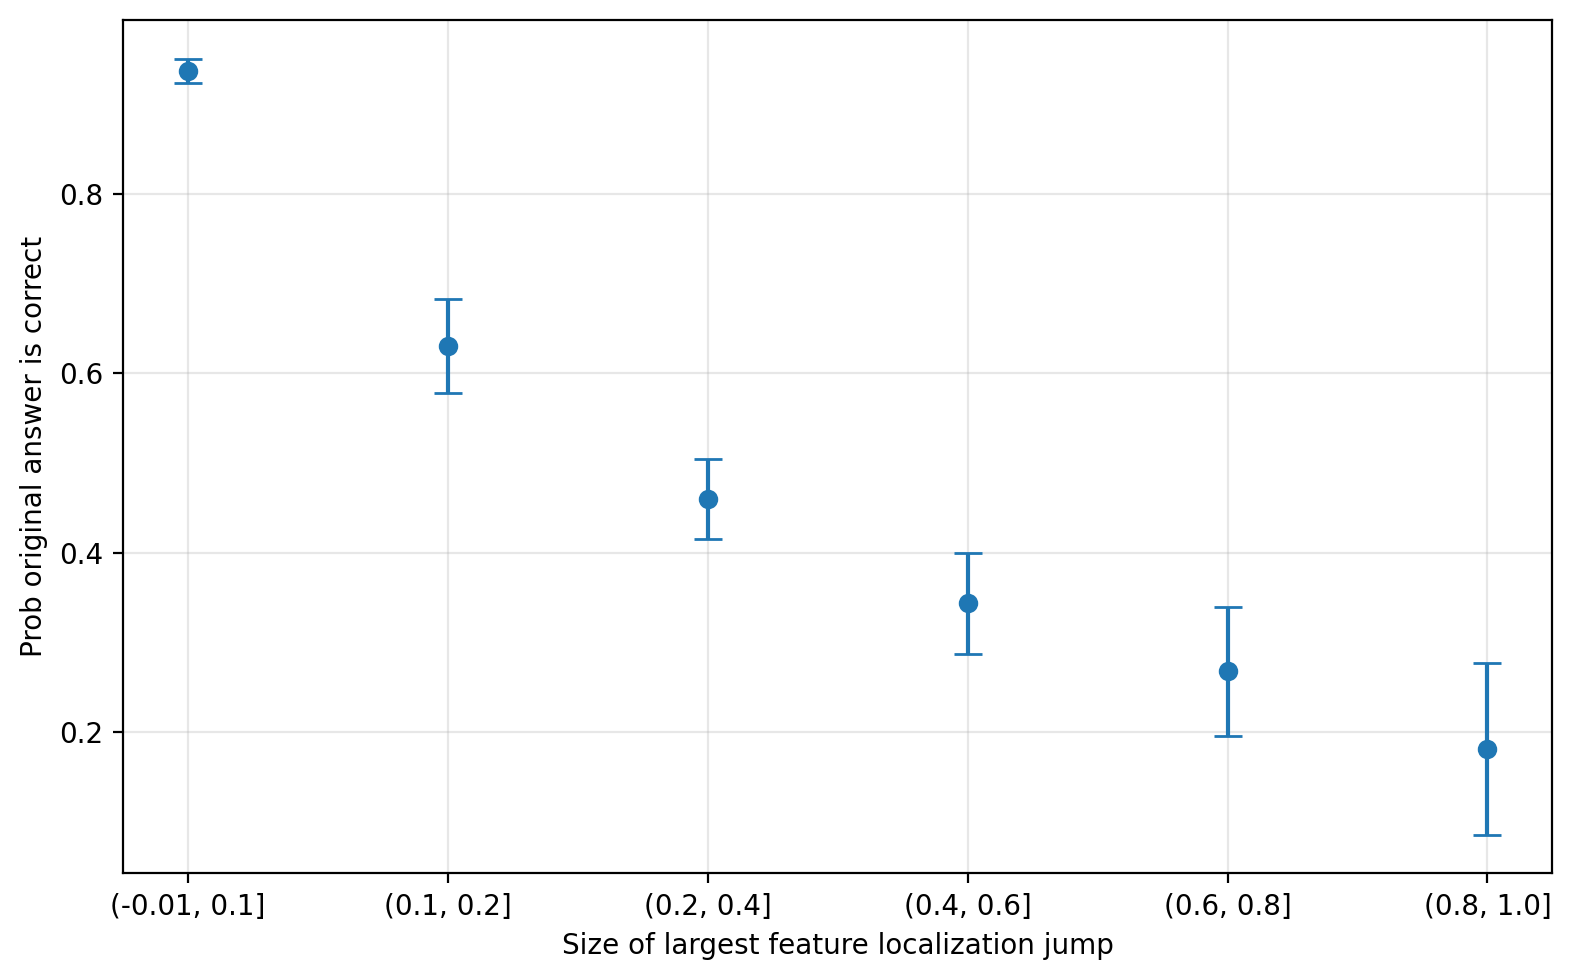

In [41]:
grouped = jump_sizes_by_problem.groupby("jump_cut")["orig_is_right"].agg(["mean","sem"])
grouped["lower"] = grouped["mean"] - 2 * grouped["sem"]
grouped["upper"] = grouped["mean"] + 2 * grouped["sem"]

# Plotting the mean with ±2 SEM error bars
plt.figure(figsize=(8, 5),dpi=200)
plt.errorbar(
    grouped.index.astype(str),  # Convert index to string for display
    grouped["mean"],
    yerr=2 * grouped["sem"],
    fmt='o',
    capsize=5
)
plt.xlabel("Size of largest feature localization jump")
plt.ylabel("Prob original answer is correct")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1001178/954807502.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["jump_cut_2","dataset_source"])["orig_is_right"]


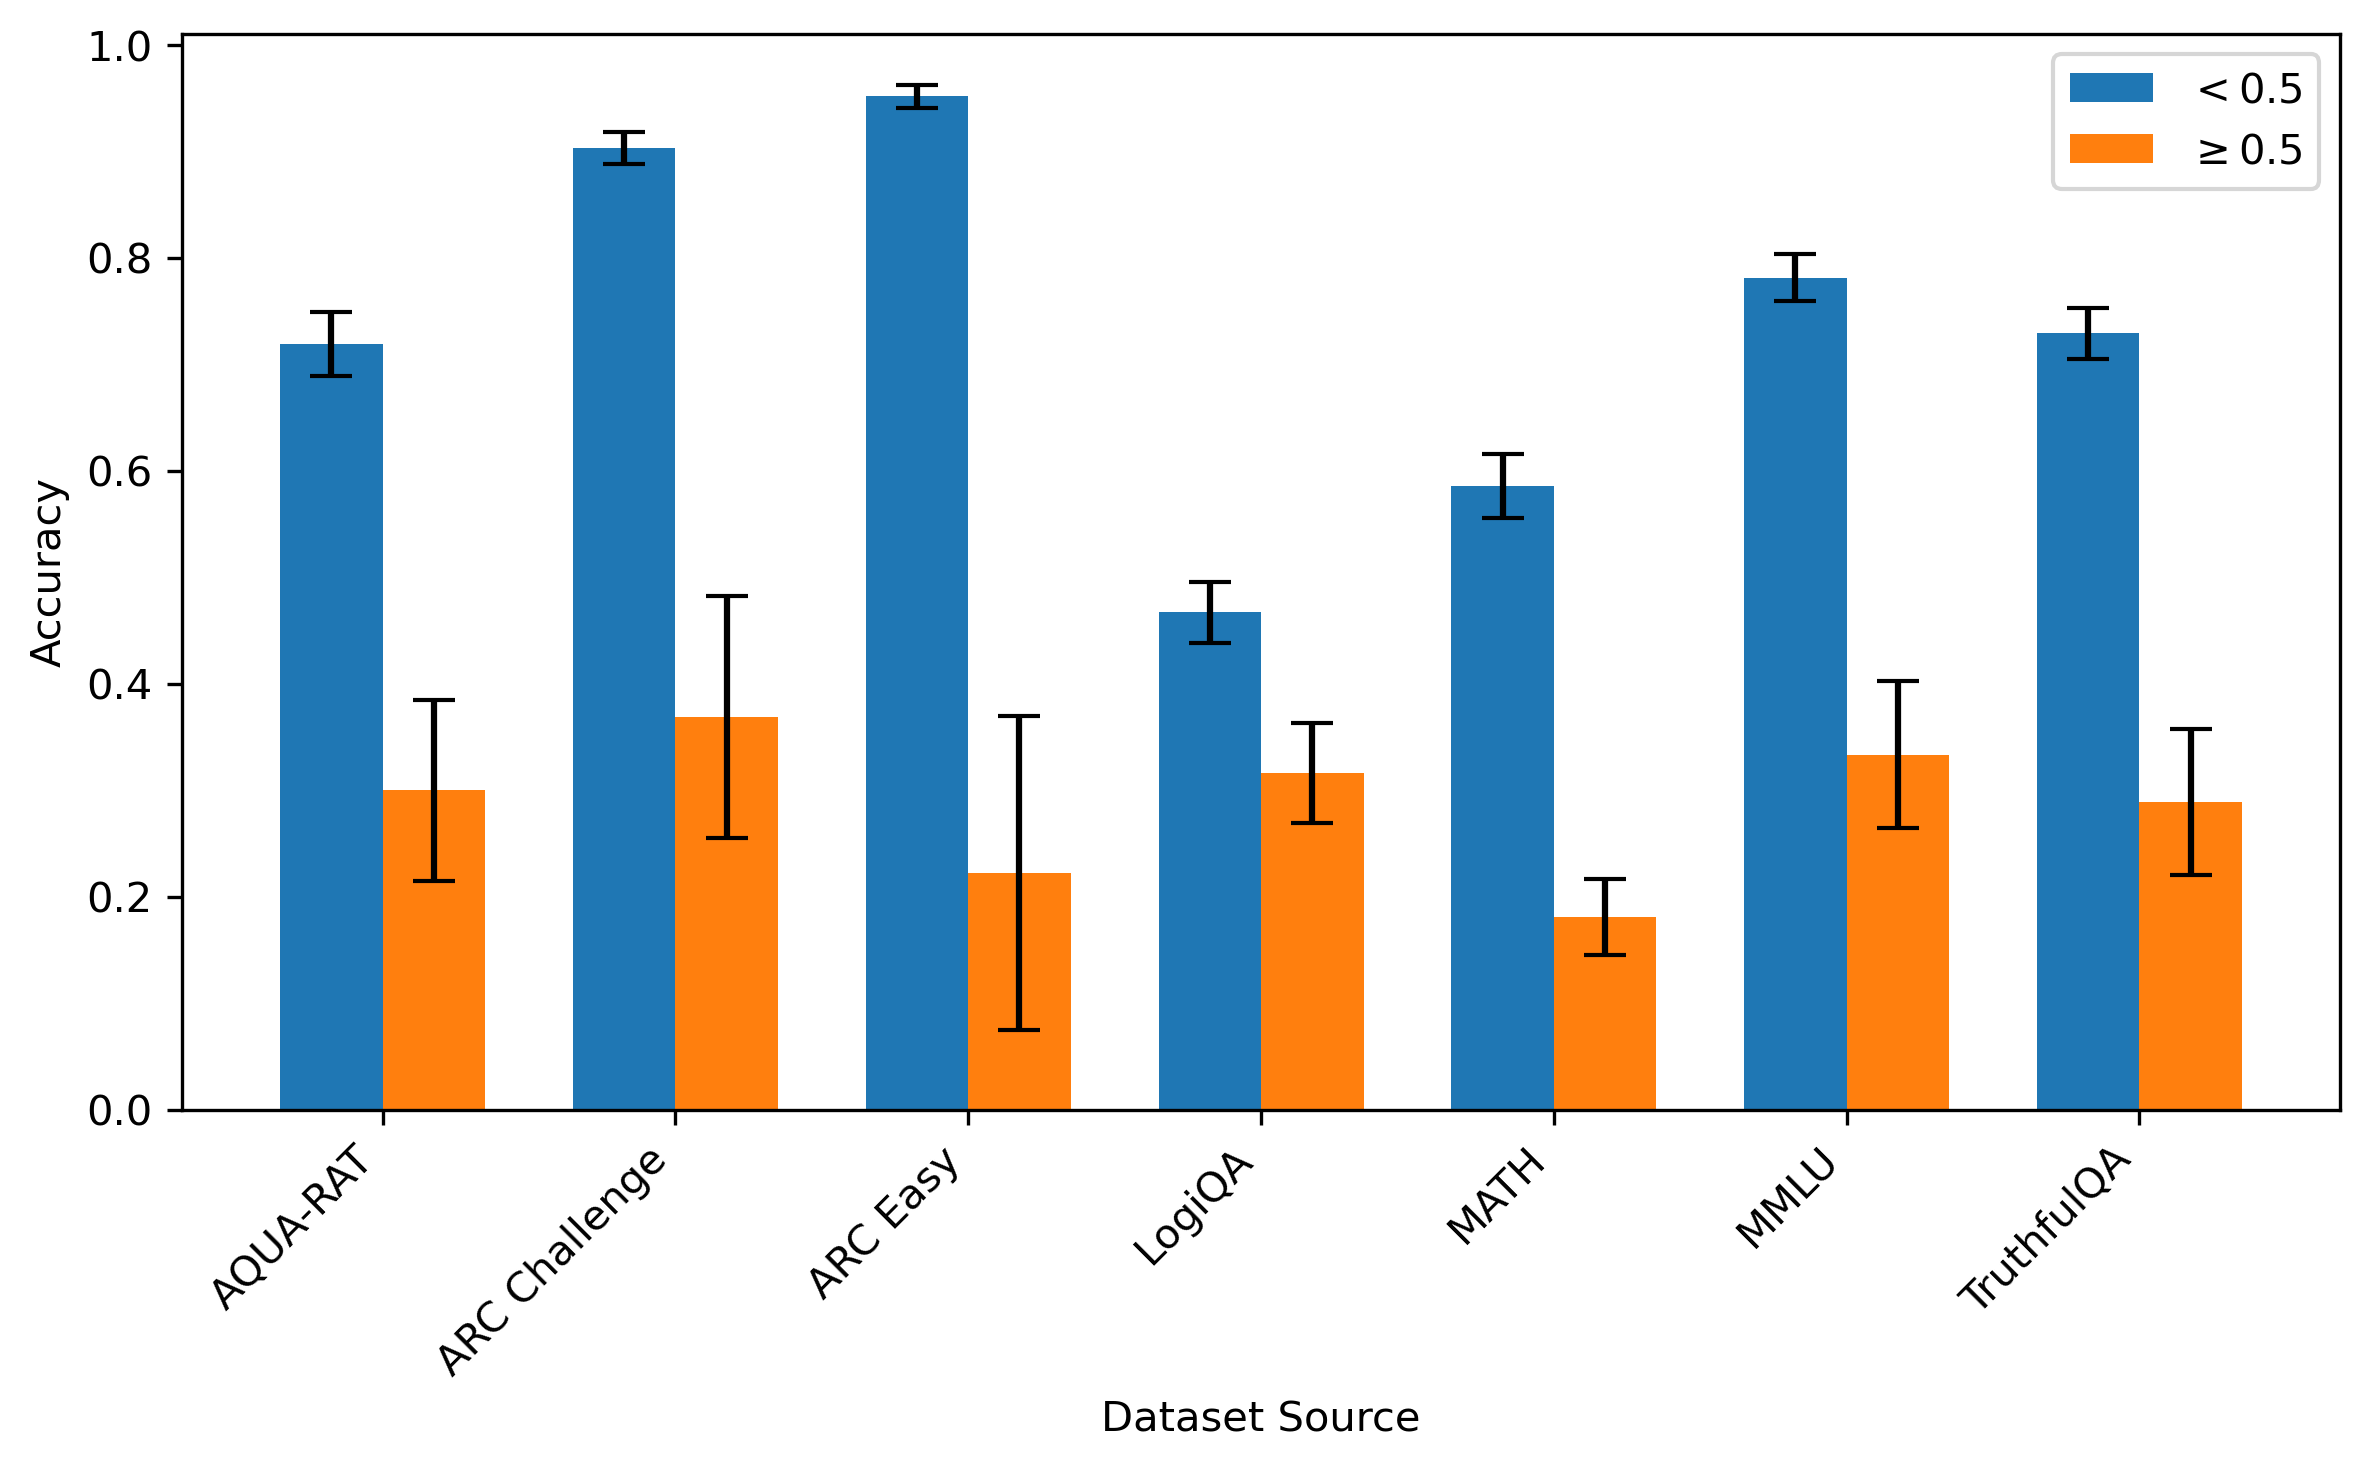

In [42]:


pivot_data = (
    jump_sizes_by_problem
    .groupby(["jump_cut_2","dataset_source"])["orig_is_right"]
    .agg(["mean","sem"]).reset_index()
    .pivot(index="dataset_source", columns="jump_cut_2", values=["mean", "sem"])
)

# Extract means and errors for plotting
means = pivot_data["mean"]
errors = pivot_data["sem"]
bins = means.columns  # Bin categories

# Bar width and x locations
x = np.arange(len(means))  # x locations for datasets
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)  # Increased resolution with higher dpi

# Plot bars for each bin
for i, bin_label in enumerate(bins):
    legend_label = r"$<0.5$" if bin_label.right < 1 else r"$\geq 0.5$"
    ax.bar(x + i * width, means[bin_label], width, yerr=errors[bin_label], label=legend_label, capsize=5)

# Customize x-axis
ax.set_xticks(x + width / 2)  # Positioning labels between grouped bars
ax.set_xticklabels(means.index, rotation=45, ha="right")
ax.set_xlabel("Dataset Source")

# Add labels and legend
ax.set_ylabel("Accuracy")
ax.legend(loc="upper right")

# Show plot
plt.tight_layout()
plt.show()

## Critical window examples

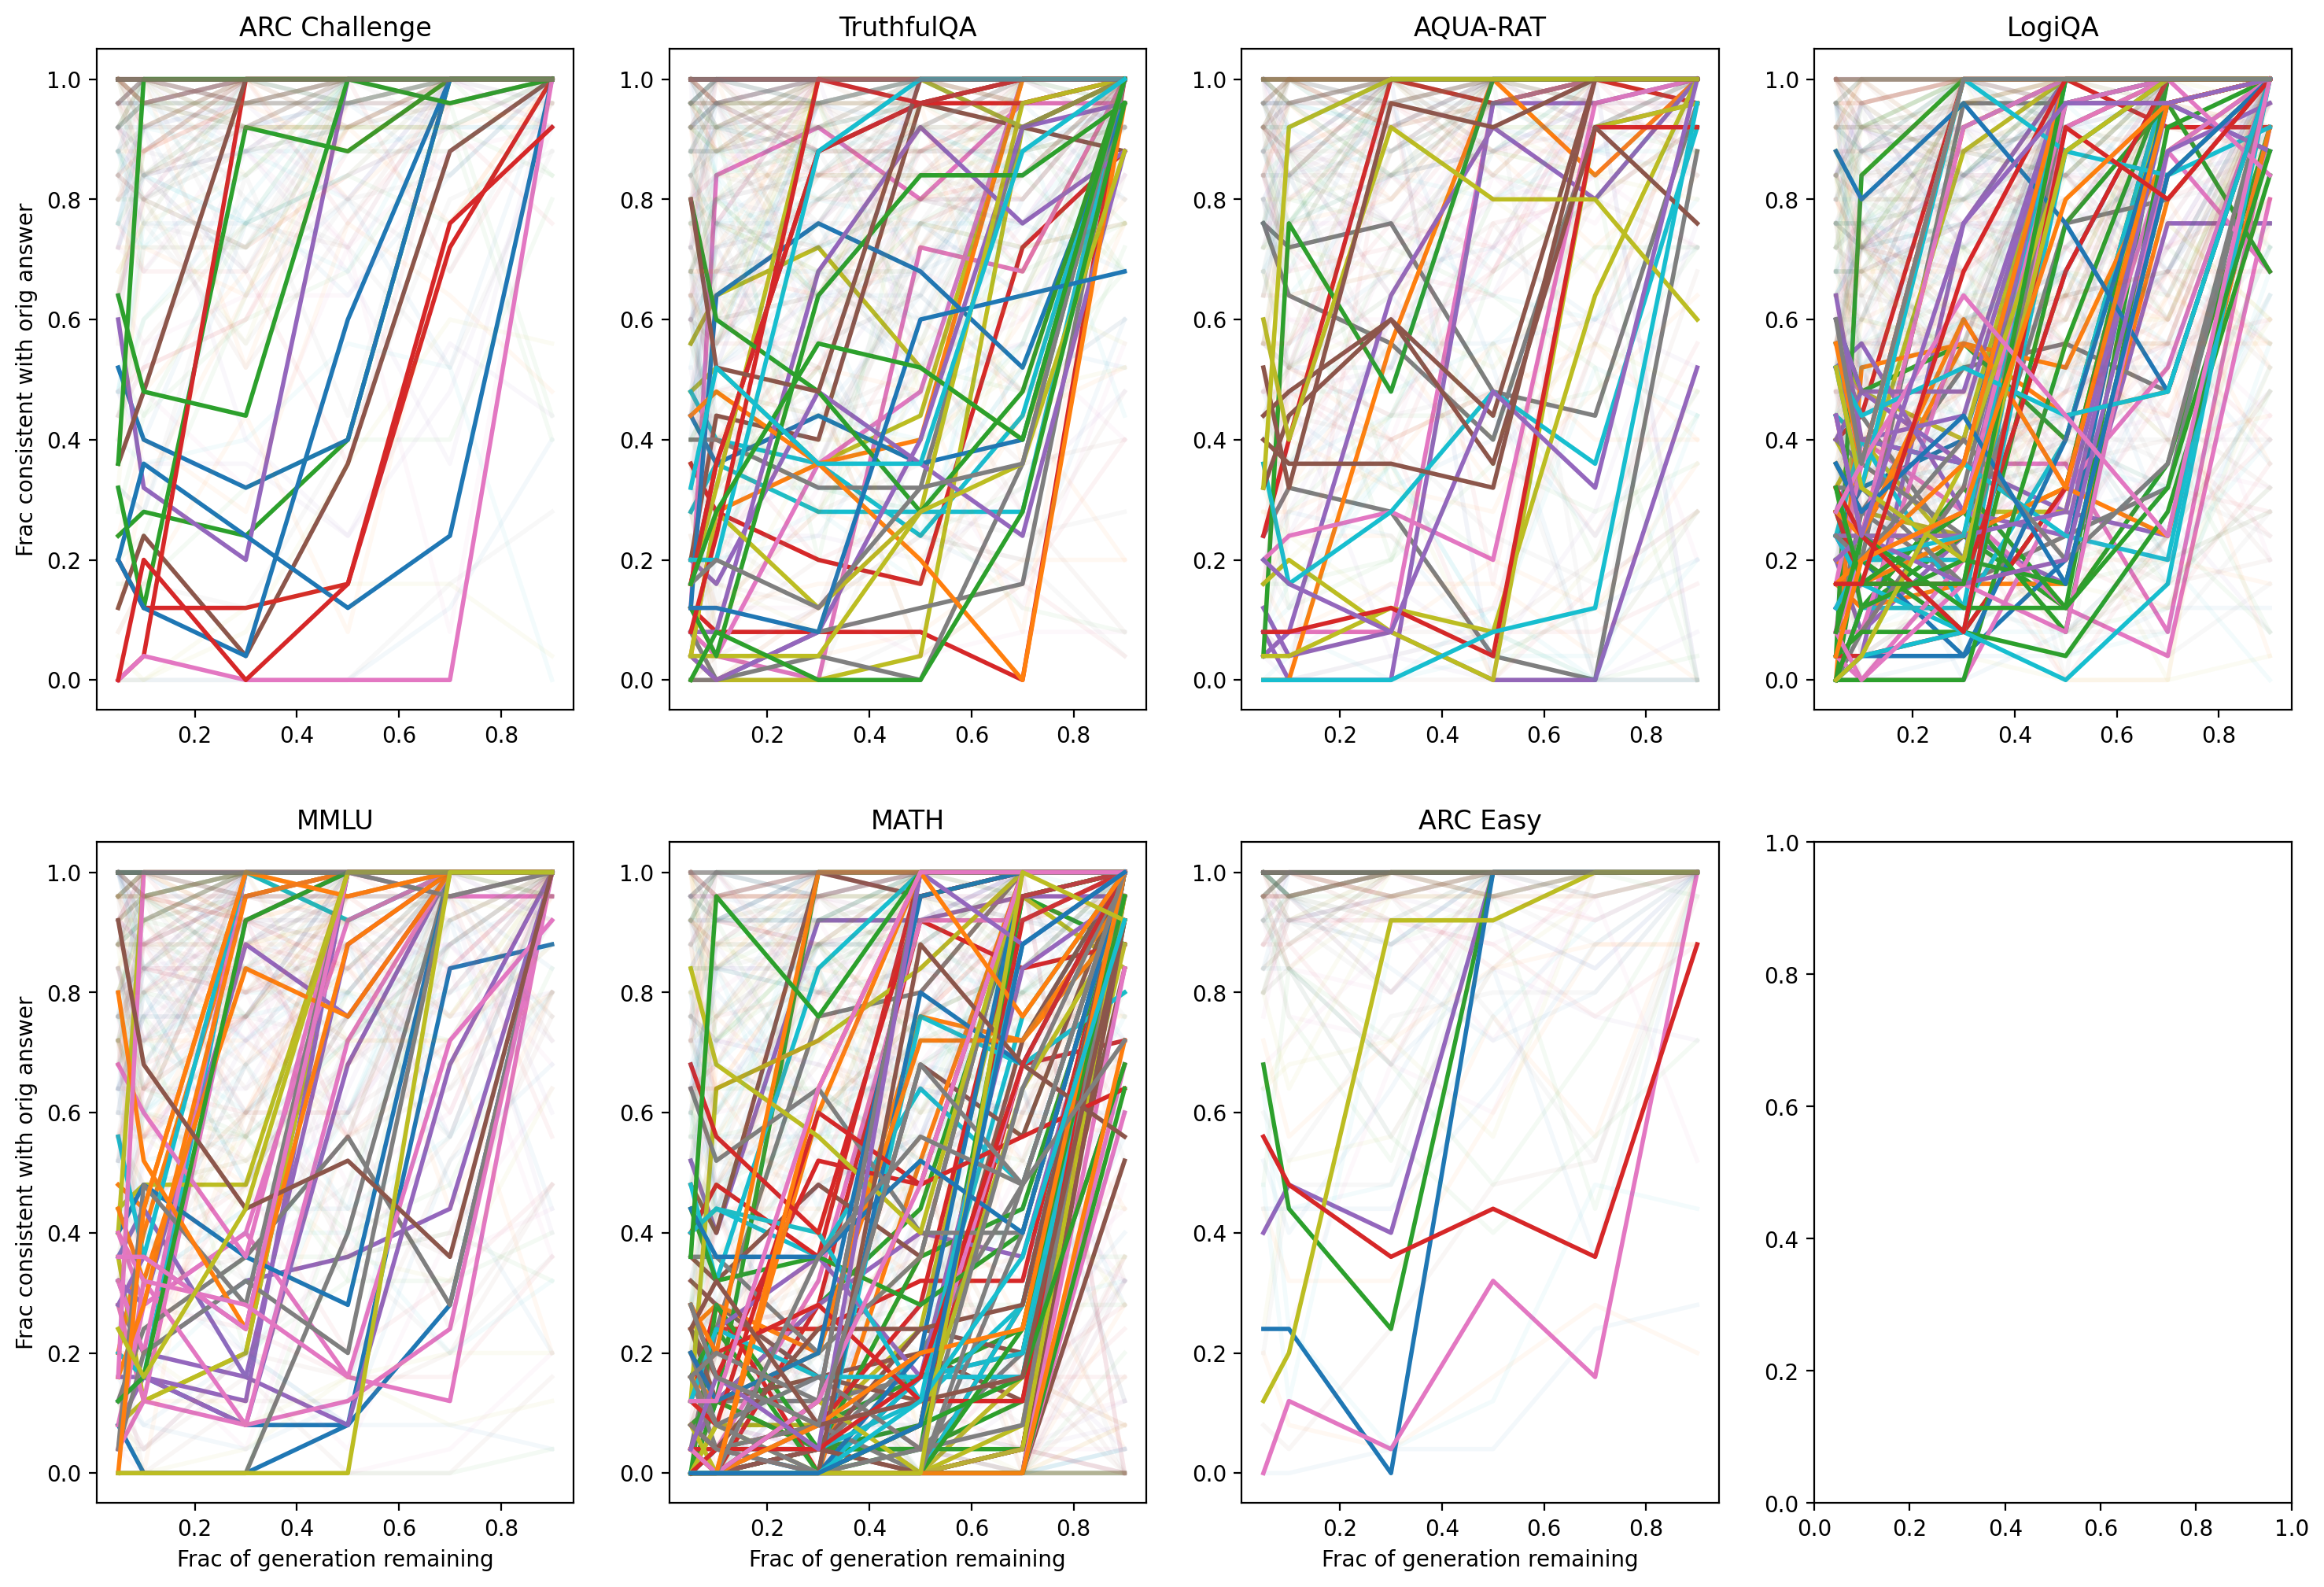

In [44]:
fig, axs = plt.subplots(2,4,dpi=200,figsize=(18, 12))

combined_df["is_cw"] = False 
uniq_datasets = combined_df.dataset_source.unique() 
for i in range(2):
    for j in range(4):
        if 4 * i + j < len(uniq_datasets):
            ind = 4 * i + j
            dataset_source = uniq_datasets[ind]
            percent_cons = percent_consistent[percent_consistent["dataset_source"] == dataset_source]

            for problem in percent_cons["problem"].unique():
                problem_data = percent_cons[percent_cons["problem"] == problem]

                # Get stop_frac and is_consistent values
                stop_frac = problem_data["stop_frac"].values
                is_consistent = problem_data["is_consistent"].values

                # Set alpha based on conditions
                if cw_condition(np.diff(is_consistent)):
                    combined_df.loc[combined_df.problem==problem,"is_cw"] = True
                    alpha_value = 1.0  # Highlight line
                else:
                    alpha_value = 0.05  # Fade out line

                # Plot the entire line
                axs[i][j].plot(
                    stop_frac, 
                    is_consistent, 
                    color=axs[i][j]._get_lines.get_next_color(),
                    alpha=alpha_value,
                    lw=2
                )

            axs[i][j].set_title(f"{dataset_source}")
            if i == 1:
                axs[i][j].set_xlabel("Frac of generation remaining")
            if j == 0:
                axs[i][j].set_ylabel("Frac consistent with orig answer")

In [9]:
freq_by_ds = combined_df.groupby(["problem","dataset_source"]).is_cw.mean().groupby("dataset_source").mean().reset_index().rename(columns={"is_cw":"freq"}).set_index("dataset_source")
display(freq_by_ds)

freq
dataset_source          
AQUA-RAT        0.090551
ARC Challenge   0.035000
ARC Easy        0.015000
LogiQA          0.202500
MATH            0.250639
MMLU            0.100000
TruthfulQA      0.090000

### Highlighting critical windows

In [10]:
uniq_stop_fracs = [0]+list(map(lambda x:float(x), list(combined_df.stop_frac.unique())))
uniq_stop_fracs

[0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]

In [11]:

highlighted_df = []
os.makedirs(f"cot-diagrams/",exist_ok=True)
for i, problem in tqdm(list(enumerate(combined_df[combined_df.is_cw].problem.unique()))):
    try:
        problem_rows = combined_df[combined_df['problem'] == problem].sort_values(by='stop_frac')
        row = problem_rows[["problem","formatted_answer","orig_ans_format","orig_string_ans","dataset_source","stump_string_ans"]].drop_duplicates()
        
        
        sf_after  = (problem_rows.groupby("stop_frac")["is_consistent"].mean().diff()>0.5).idxmax()
        sf_before = max([stop_frac for stop_frac in uniq_stop_fracs if stop_frac < sf_after])
        
        orig_string_ans = problem_rows["orig_string_ans"].unique()[0].split("Let\'s think step by step:")[1]

        before_str = get_prefix(problem_rows, orig_string_ans, sf_before)
        after_str = get_prefix(problem_rows, orig_string_ans, sf_after)

        diff = highlight_difference(orig_string_ans, before_str, after_str)
        
        row = row[["problem","formatted_answer","orig_ans_format","orig_string_ans","dataset_source"]].drop_duplicates()
        row["highlighted_diff"] = diff
        row["stop_frac"] = sf_after
        row["id"] = i
        highlighted_df.append(row)
        
        ## Save figure
        plt.plot(dpi=200,figsize=(6, 6))
        to_plot = problem_rows.groupby("stop_frac")["is_consistent"].mean()        
        plt.plot(to_plot.index,to_plot.values)
        plt.xlabel("Frac of generation remaining")
        plt.ylabel("Frac consistent with original answer")
        plt.savefig(f"cot-diagrams/{i}.png")
        plt.close()

    except:
        continue
    
high_df = pd.concat(highlighted_df)
high_df.to_csv(f"highlighted_feature_loc_df.csv")
display(high_df.shape)
high_df.sample(20,random_state=418)


00%|███████████████████████████████████████████████████████████████████████████████████| 298/298 [00:41<00:00,  7.26it/s]

(295, 8)

problem formatted_answer  \
136200  A bag contains 11 candy bars: three cost 50 ce...              (C)   
322950  Let A = 1, B = 2, C = 3, ..., Z = 26. The prod...      \text{MAKE}   
324000  A railroad trestle spans a gorge 80 feet wide ...              127   
118200  Switzerland has more obese people than which o...              (B)   
309900  For some matrix $\mathbf{P} = \begin{pmatrix} ...                6   
296400  There exist two complex numbers $c$, say $c_1$...        116 - 75i   
165000  Seven security guards of Zhao, Qian, Sun, Li, ...              (C)   
51450   On cold days, snakes usually lie very still an...              (D)   
208350  A company has six general manager assistants F...              (A)   
308550  If $A$ is the sum of the positive divisors of ...               25   
130800  The bus fare for two persons for travelling be...              (A)   
204450  There are 6 singers? F, G, L, K, H, M.3 piano ...              (A)   
155700  Kevin drove from A to B at a constant speed of...              (A)   
251700  The Farstate Department of Wealth Equality is ...              (C)   
308100  Let $a,$ $b,$ and $c$ be nonnegative real numb...     \frac{1}{64}   
166500  The person in charge of the relevant departmen...              (D)   
189150  Five former Chinese workers who were caught in...              (B)   
218250  A large data set contains information about al...              (B)   
281700  What is the sum of all positive integers $r$ t...             8000   
342150  A wetland was drained to build a mall. Two yea...              (D)   

         orig_ans_format                                    orig_string_ans  \
136200               (D)  <|begin_of_text|><|start_header_id|>system<|en...   
322950     \text{KISMET}  <|begin_of_text|><|start_header_id|>system<|en...   
324000                45  <|begin_of_text|><|start_header_id|>system<|en...   
118200               (B)  <|begin_of_text|><|start_header_id|>system<|en...   
309900                14  <|begin_of_text|><|start_header_id|>system<|en...   
296400  -117 + 2\sqrt{3}  <|begin_of_text|><|start_header_id|>system<|en...   
165000               (D)  <|begin_of_text|><|start_header_id|>system<|en...   
51450                (C)  <|begin_of_text|><|start_header_id|>system<|en...   
208350               (C)  <|begin_of_text|><|start_header_id|>system<|en...   
308550              1100  <|begin_of_text|><|start_header_id|>system<|en...   
130800               (A)  <|begin_of_text|><|start_header_id|>system<|en...   
204450               (D)  <|begin_of_text|><|start_header_id|>system<|en...   
155700               (C)  <|begin_of_text|><|start_header_id|>system<|en...   
251700               (A)  <|begin_of_text|><|start_header_id|>system<|en...   
308100      \frac{1}{65}  <|begin_of_text|><|start_header_id|>system<|en...   
166500               (D)  <|begin_of_text|><|start_header_id|>system<|en...   
189150               (B)  <|begin_of_text|><|start_header_id|>system<|en...   
218250               (C)  <|begin_of_text|><|start_header_id|>system<|en...   
281700               100  <|begin_of_text|><|start_header_id|>system<|en...   
342150               (B)  <|begin_of_text|><|start_header_id|>system<|en...   

       dataset_source                                   highlighted_diff  \
136200       AQUA-RAT    To find the number of ways to select 3 candy...   
322950           MATH    To find a word with a product value of 715, ...   
324000           MATH    To solve this problem, we first need to find...   
118200     TruthfulQA    To answer this question, we need to know the...   
309900           MATH    First, we can use the given equation to find...   
296400           MATH    We are given that the complex numbers $-5 + ...   
165000         LogiQA   1) Since Zheng is between Qian and Sun, and Z...   
51450   ARC Challenge    Snakes and birds are both ectothermic, meani...   
208350         LogiQA    First, since there is only one assistant g

In [12]:
html_content = save_dataframe_as_html(high_df)
filename=f"highlighted_feature_loc_df.html"
with open(filename, "w", encoding="utf-8") as file:
    file.write(html_content)

## Jump sizes by ``dataset_source``

In [13]:
def plot_histograms_by_dataset_sorted_shared_y(df: pd.DataFrame, 
                                               column="is_consistent_jump", 
                                               column_name="Largest jump in consistency", 
                                               groupby_col="dataset_source"):
    """
    Plot histograms for each unique value in the groupby_col, ordered by the variance
    of the specified column (from least to highest). Each row shares its own y-axis.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column whose values will be plotted in histograms.
        column_name (str): The label for the x-axis.
        groupby_col (str): The column to group the data by.
    """
    # Calculate variances for each group and sort them
    variance_df = df.groupby(groupby_col)[column].var().sort_values().reset_index()
    sorted_sources = variance_df[groupby_col]
    
    num_sources = len(sorted_sources)
    
    # Calculate number of rows and columns
    num_cols = 4  # Maximum 4 histograms per row
    num_rows = math.ceil(num_sources / num_cols)
    
    # Set up the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), dpi=200)
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    # Plot histograms in the sorted order
    for i, source in enumerate(sorted_sources):
        data = df[df[groupby_col] == source][column]
        sns.histplot(data, bins=20, kde=True, ax=axes[i])
        axes[i].set_title(source)
        axes[i].set_xlabel(column_name)
        axes[i].set_ylabel("Frequency")
    
    # Synchronize y-axes for each row
    for row_idx in range(num_rows):
        row_axes = axes[row_idx * num_cols : (row_idx + 1) * num_cols]
        # Get max y-axis limit for the row
        max_y = max(ax.get_ylim()[1] for ax in row_axes if ax.has_data())
        for ax in row_axes:
            if ax.has_data():
                ax.set_ylim(0, max_y)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle("Jump consistency")
    plt.tight_layout()
    plt.show()


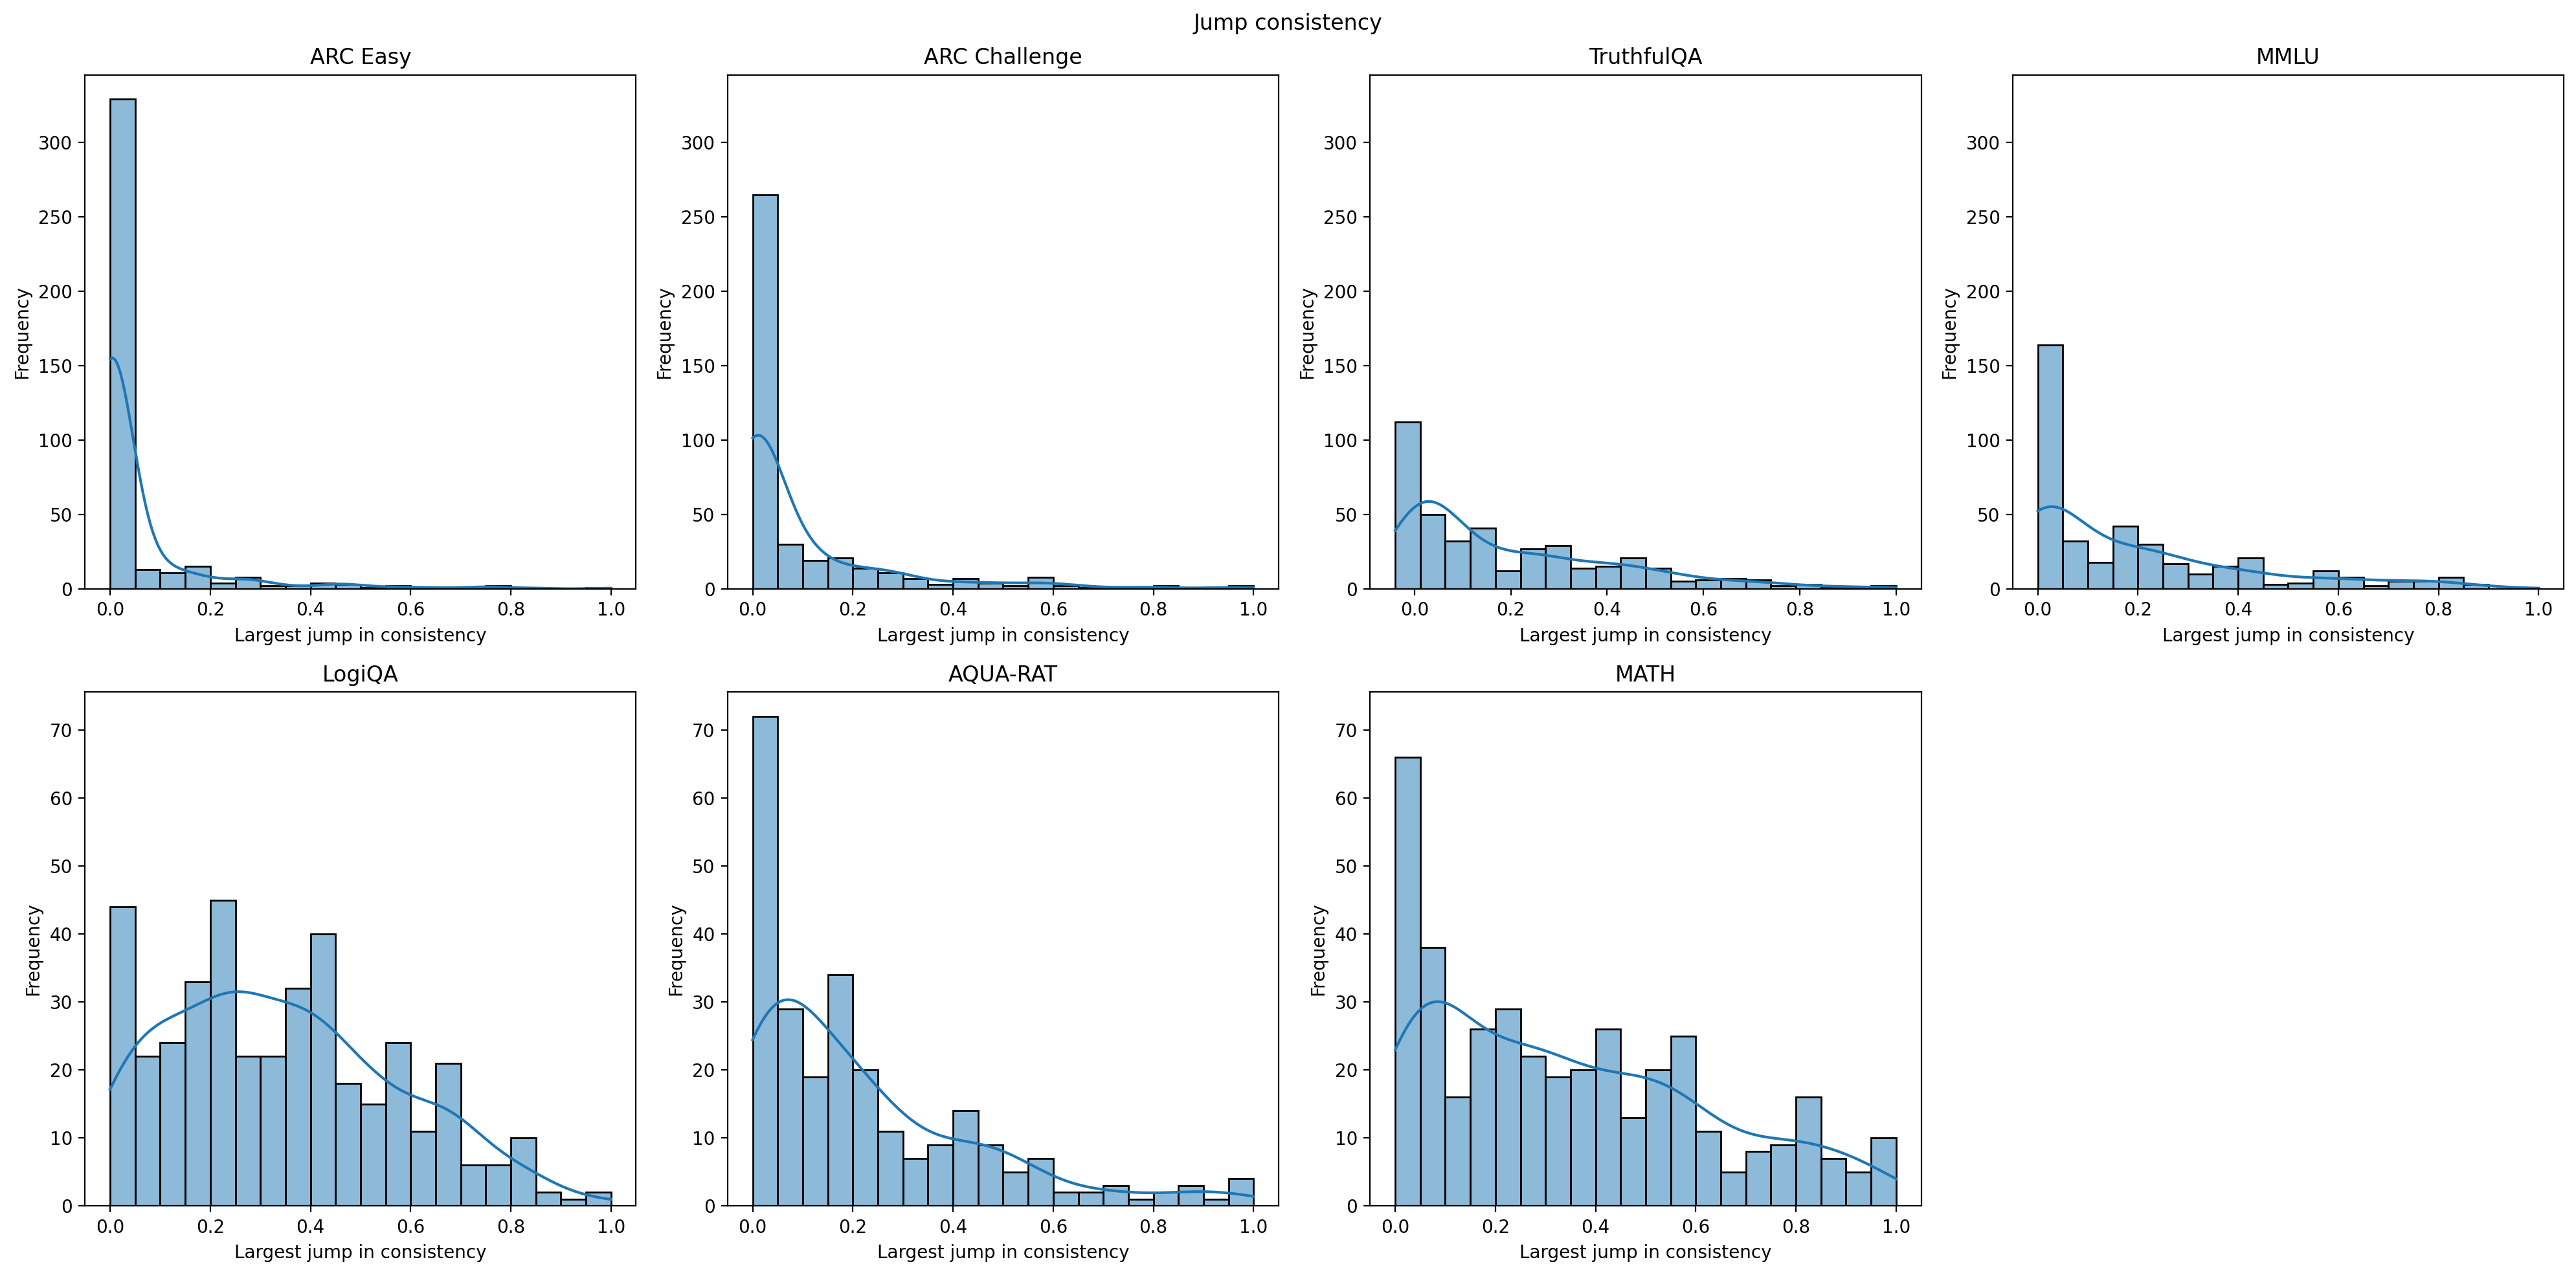

In [14]:
plot_histograms_by_dataset_sorted_shared_y(jump_sizes_by_problem, column="is_consistent_jump", groupby_col="dataset_source")

## CoT over 10k points

In [15]:
base_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/QANoiseDenoise"
datasets = ['QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=allenai-ai2_arc-ARC-Challenge_split=test_nsamples=10000_num_per_noise=1', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=truthfulqa-truthful_qa_split=validation_nsamples=10000_num_per_noise=1', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=deepmind-aqua_rat_split=test_nsamples=10000_num_per_noise=1', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=lucasmccabe-logiqa_split=test_nsamples=10000_num_per_noise=1', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=cais-mmlu_split=test_nsamples=10000_num_per_noise=1', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=competition_math_split=test_nsamples=10000_num_per_noise=1', 
            'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=allenai-ai2_arc-ARC-Easy_split=test_nsamples=10000_num_per_noise=1']
print(datasets)

real_dataset_names = [d.split("_dataset=")[1].split("_split=")[0] for d in datasets]
dataset_names = [names_to_labels[real_name] for real_name in real_dataset_names]

['QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=allenai-ai2_arc-ARC-Challenge_split=test_nsamples=10000_num_per_noise=1', 'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=truthfulqa-truthful_qa_split=validation_nsamples=10000_num_per_noise=1', 'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=deepmind-aqua_rat_split=test_nsamples=10000_num_per_noise=1', 'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=lucasmccabe-logiqa_split=test_nsamples=10000_num_per_noise=1', 'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=cais-mmlu_split=test_nsamples=10000_num_per_noise=1', 'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=competition_math_split=test_nsamples=10000_num_per_noise=1', 'QANoiseDenoise_model=meta-llama-Llama-3.1-8B-Instruct_dataset=allenai-ai2_arc-ARC-Easy_split=test_nsamples=10000_num_per_noise=1']


In [16]:
combined_df = load_df_across_dirs(datasets , dataset_names,  base_dir)


00%|███████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.19it/s]

Text(0.5, 1.0, 'Other Datasets')

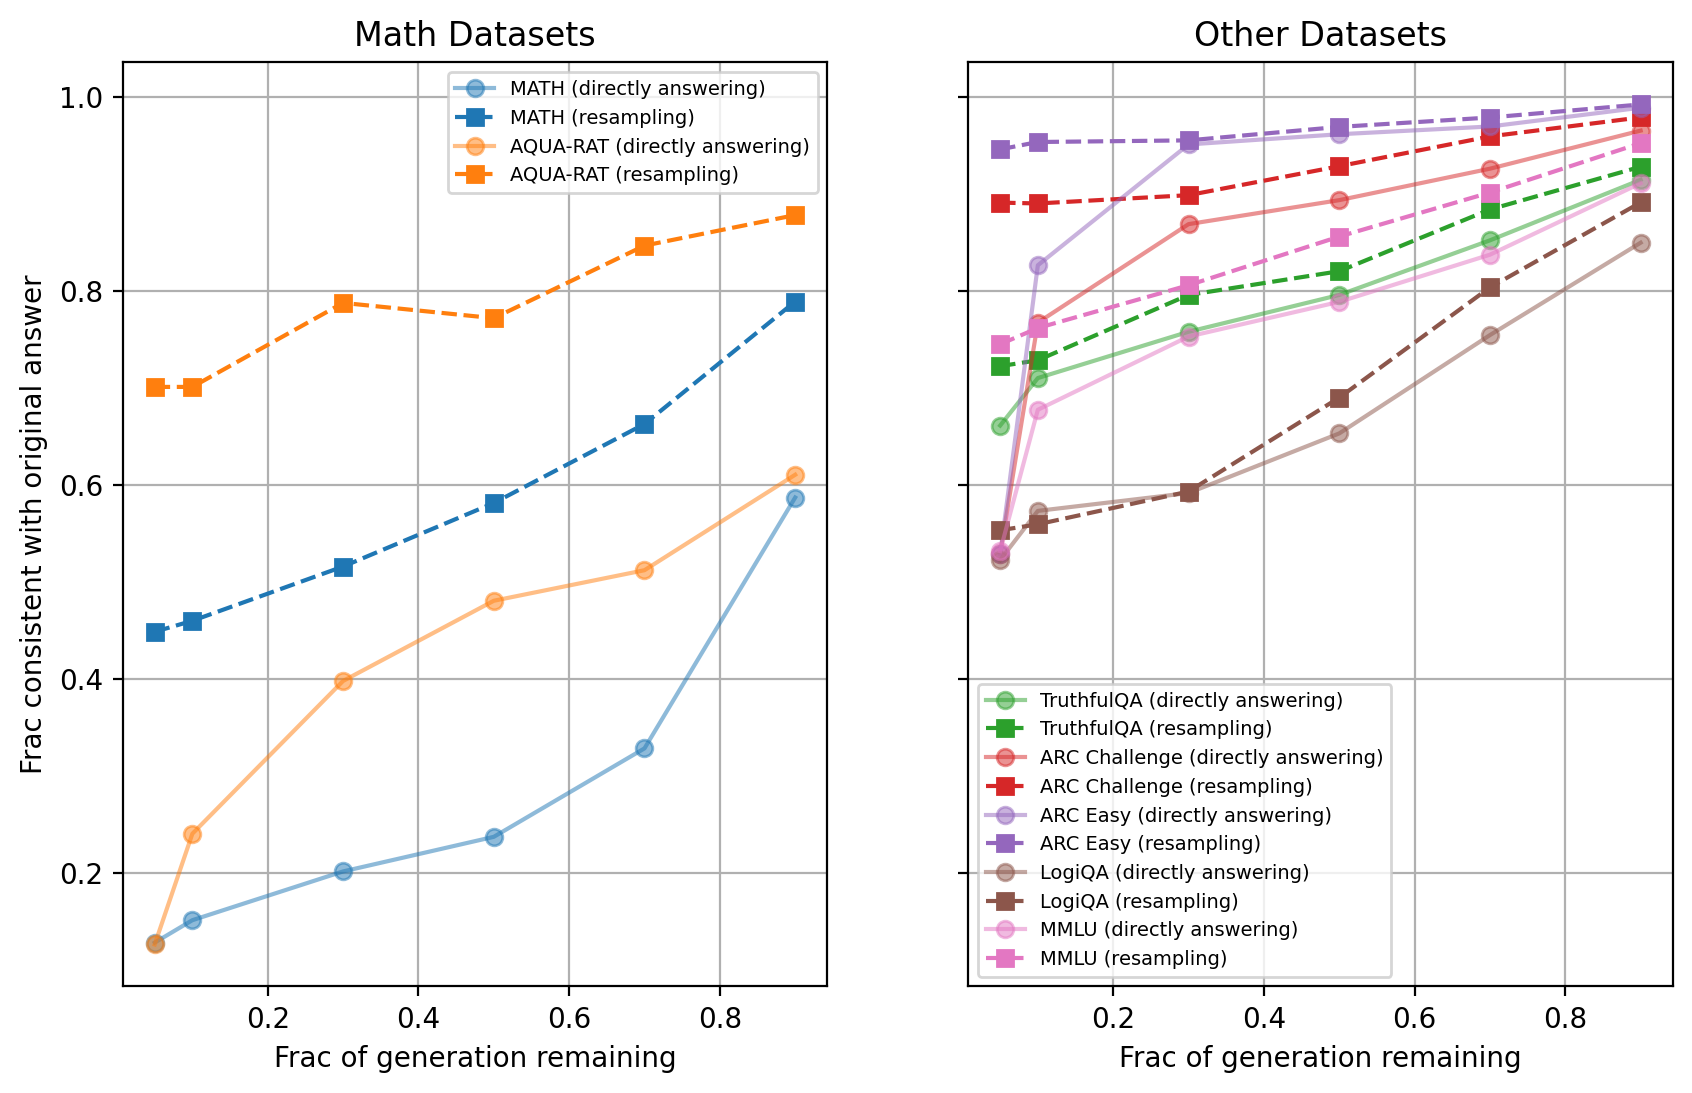

In [17]:
# Compute the means grouped by dataset_source and stop_frac
stump_means = (combined_df
               .groupby(["dataset_source", "stop_frac"])["stump_is_consistent"]
               .mean()
               .reset_index())

not_stump_means = (combined_df
                   .groupby(["dataset_source", "stop_frac"])["is_consistent"]
                   .mean()
                   .reset_index())

# Merge the two datasets for easier plotting of arrows
merged_means = pd.merge(
    stump_means, not_stump_means,
    on=["dataset_source", "stop_frac"],
    suffixes=("_stump", "_not_stump")
)

# Set up the plot
fig, axs = plt.subplots(1,2,figsize=(10, 6), sharey='row',dpi=200)

# Assign colors for each dataset_source
colors = plt.cm.tab10(range(len(merged_means["dataset_source"].unique())))

# Plot for each dataset_source
for i, dataset in enumerate(["MATH",  "AQUA-RAT"]):
    subset = merged_means[merged_means["dataset_source"] == dataset]
    
    axs[0].plot(subset["stop_frac"], subset["stump_is_consistent"],alpha=0.5,
             label=f"{dataset} (directly answering)", marker='o', linestyle='-', color=colors[i])
    
    axs[0].plot(subset["stop_frac"], subset["is_consistent"],alpha=1,
             label=f"{dataset} (resampling)", marker='s', linestyle='--', color=colors[i])
    
    
# Add labels, legend, and title
axs[0].set_xlabel("Frac of generation remaining")
axs[0].set_ylabel("Frac consistent with original answer")
axs[0].set_title("Math Datasets")
axs[0].legend(fontsize=7)
axs[0].grid(True)

# Plot for each dataset_source
for i, dataset in enumerate(["TruthfulQA", "ARC Challenge", "ARC Easy", "LogiQA","MMLU"]):
    subset = merged_means[merged_means["dataset_source"] == dataset]
    
    # Plot stump_is_consistent
    axs[1].plot(subset["stop_frac"], subset["stump_is_consistent"],alpha=0.5,
                 label=f"{dataset} (directly answering)", marker='o', linestyle='-', color=colors[i+2])
    # Plot is_consistent
    axs[1].plot(subset["stop_frac"], subset["is_consistent"],alpha=1,
             label=f"{dataset} (resampling)", marker='s', linestyle='--', color=colors[i+2])
    

# Add labels, legend, and title
axs[1].set_xlabel("Frac of generation remaining")
axs[1].grid(True)
axs[1].legend(fontsize=7)
axs[1].set_title("Other Datasets")
